#Module

In [11]:
from Bio import SeqIO
import pandas as pd
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
# Fungsi untuk menghasilkan K-mers dengan panjang 3 dari urutan DNA
def get_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Fungsi untuk membuat mapping manual dari K-mers ke angka
def create_kmer_mapping(kmers_list):
    unique_kmers = set([kmer for kmers in kmers_list for kmer in kmers])
    kmer_to_index = {kmer: idx + 1 for idx, kmer in enumerate(unique_kmers)}
    return kmer_to_index

# Fungsi untuk mengonversi K-mers ke angka berdasarkan mapping
def map_kmers_to_indices(kmers, kmer_mapping):
    return [kmer_mapping[kmer] for kmer in kmers]

In [13]:
df = pd.read_excel("../Dataset/Dataset_Preprocess.xlsx")
df = df[['urutan', 'kelas']]

In [14]:
df

,urutan,kelas
0,AGTTGTTAGTCTACGTGGACCGACAAAGACAGATTCTTTGAGGGAG...,0
1,AGTTGTTAGTCTACGTGGACCGACAAGAACAGTTTCGAATCGGAAG...,0
2,GTGGACCGCAAAGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAG...,0
3,TTTCATTTTACCACACGTAACGGAGAACCACACATGATCGTCGGTA...,0
4,ATGAATAACCAACGAAAAAATGCGAGAAAAACGCCTTTCAATATGC...,0
...,...,...
1251,ATGAATAACCAACGGAAAAAGGCGAAAAACACGCCTTTCAATATGC...,1
1252,ATGAATAACCAACGGAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1
1253,ATGAACAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1
1254,ATGAATAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1


In [15]:
df['kmers'] = df['urutan'].apply(lambda x: get_kmers(x, 3))
df

,urutan,kelas,kmers
0,AGTTGTTAGTCTACGTGGACCGACAAAGACAGATTCTTTGAGGGAG...,0,"[AGT, GTT, TTG, TGT, GTT, TTA, TAG, AGT, GTC, ..."
1,AGTTGTTAGTCTACGTGGACCGACAAGAACAGTTTCGAATCGGAAG...,0,"[AGT, GTT, TTG, TGT, GTT, TTA, TAG, AGT, GTC, ..."
2,GTGGACCGCAAAGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAG...,0,"[GTG, TGG, GGA, GAC, ACC, CCG, CGC, GCA, CAA, ..."
3,TTTCATTTTACCACACGTAACGGAGAACCACACATGATCGTCGGTA...,0,"[TTT, TTC, TCA, CAT, ATT, TTT, TTT, TTA, TAC, ..."
4,ATGAATAACCAACGAAAAAATGCGAGAAAAACGCCTTTCAATATGC...,0,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."
...,...,...,...
1251,ATGAATAACCAACGGAAAAAGGCGAAAAACACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."
1252,ATGAATAACCAACGGAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."
1253,ATGAACAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAC, ACA, CAA, AAC, ACC, CCA, ..."
1254,ATGAATAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ..."


TF-IDF

In [17]:
df['kmers_str'] = df['kmers'].apply(lambda x: ' '.join(x))

Memangkas yang panjang menjadi 145 - karena terpendeknya 145

In [18]:
def truncate_to_length(kmers_str, target_length=145):
    return kmers_str[:target_length]

df['kmers_str_adjusted'] = df['kmers_str'].apply(truncate_to_length)


In [20]:
df

,urutan,kelas,kmers,kmers_str,kmers_str_adjusted
0,AGTTGTTAGTCTACGTGGACCGACAAAGACAGATTCTTTGAGGGAG...,0,"[AGT, GTT, TTG, TGT, GTT, TTA, TAG, AGT, GTC, ...",AGT GTT TTG TGT GTT TTA TAG AGT GTC TCT CTA TA...,AGT GTT TTG TGT GTT TTA TAG AGT GTC TCT CTA TA...
1,AGTTGTTAGTCTACGTGGACCGACAAGAACAGTTTCGAATCGGAAG...,0,"[AGT, GTT, TTG, TGT, GTT, TTA, TAG, AGT, GTC, ...",AGT GTT TTG TGT GTT TTA TAG AGT GTC TCT CTA TA...,AGT GTT TTG TGT GTT TTA TAG AGT GTC TCT CTA TA...
2,GTGGACCGCAAAGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAG...,0,"[GTG, TGG, GGA, GAC, ACC, CCG, CGC, GCA, CAA, ...",GTG TGG GGA GAC ACC CCG CGC GCA CAA AAA AAG AG...,GTG TGG GGA GAC ACC CCG CGC GCA CAA AAA AAG AG...
3,TTTCATTTTACCACACGTAACGGAGAACCACACATGATCGTCGGTA...,0,"[TTT, TTC, TCA, CAT, ATT, TTT, TTT, TTA, TAC, ...",TTT TTC TCA CAT ATT TTT TTT TTA TAC ACC CCA CA...,TTT TTC TCA CAT ATT TTT TTT TTA TAC ACC CCA CA...
4,ATGAATAACCAACGAAAAAATGCGAGAAAAACGCCTTTCAATATGC...,0,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ...",ATG TGA GAA AAT ATA TAA AAC ACC CCA CAA AAC AC...,ATG TGA GAA AAT ATA TAA AAC ACC CCA CAA AAC AC...
...,...,...,...,...,...
1251,ATGAATAACCAACGGAAAAAGGCGAAAAACACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ...",ATG TGA GAA AAT ATA TAA AAC ACC CCA CAA AAC AC...,ATG TGA GAA AAT ATA TAA AAC ACC CCA CAA AAC AC...
1252,ATGAATAACCAACGGAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ...",ATG TGA GAA AAT ATA TAA AAC ACC CCA CAA AAC AC...,ATG TGA GAA AAT ATA TAA AAC ACC CCA CAA AAC AC...
1253,ATGAACAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAC, ACA, CAA, AAC, ACC, CCA, ...",ATG TGA GAA AAC ACA CAA AAC ACC CCA CAA AAC AC...,ATG TGA GAA AAC ACA CAA AAC ACC CCA CAA AAC AC...
1254,ATGAATAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1,"[ATG, TGA, GAA, AAT, ATA, TAA, AAC, ACC, CCA, ...",ATG TGA GAA AAT ATA TAA AAC ACC CCA CAA AAC AC...,ATG TGA GAA AAT ATA TAA AAC ACC CCA CAA AAC AC...


In [8]:
vectorizer = TfidfVectorizer(max_features=145)

X - y

In [9]:
X = vectorizer.fit_transform(df['kmers_str_adjusted'])
y = df['kelas'].values


print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1256, 64)
Shape of y: (1256,)


In [10]:
X_array = X.toarray()
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X_array, columns=feature_names)

tfidf_df

,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tcg,tct,tga,tgc,tgg,tgt,tta,ttc,ttg,ttt
0,0.135357,0.000000,0.132918,0.000000,0.194617,0.179553,0.146116,0.0,0.191150,0.000000,...,0.000000,0.304719,0.000000,0.000000,0.116680,0.138146,0.178405,0.115966,0.103789,0.000000
1,0.000000,0.095891,0.136650,0.000000,0.200081,0.184594,0.150219,0.0,0.098259,0.000000,...,0.160753,0.156637,0.000000,0.000000,0.119956,0.142025,0.183415,0.119222,0.106703,0.120909
2,0.143078,0.098593,0.280999,0.136333,0.102859,0.189795,0.000000,0.0,0.101027,0.172466,...,0.330564,0.000000,0.000000,0.126762,0.123335,0.000000,0.000000,0.122581,0.109709,0.124316
3,0.000000,0.140095,0.000000,0.000000,0.219236,0.269688,0.219466,0.0,0.071777,0.000000,...,0.000000,0.000000,0.098973,0.000000,0.000000,0.000000,0.133982,0.087091,0.000000,0.264968
4,0.719584,0.212508,0.000000,0.195903,0.000000,0.136362,0.221938,0.0,0.072585,0.000000,...,0.000000,0.000000,0.100088,0.091075,0.000000,0.000000,0.000000,0.000000,0.000000,0.089317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,0.668869,0.230453,0.109469,0.106223,0.080142,0.147877,0.240679,0.0,0.000000,0.000000,...,0.000000,0.000000,0.108539,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096859
1252,0.396747,0.182261,0.259731,0.126014,0.000000,0.175430,0.285522,0.0,0.093380,0.000000,...,0.000000,0.000000,0.128762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.114906
1253,0.493070,0.254824,0.242092,0.000000,0.088617,0.163515,0.266131,0.0,0.087039,0.000000,...,0.000000,0.000000,0.120018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107103
1254,0.498539,0.171767,0.244778,0.118759,0.000000,0.165329,0.269083,0.0,0.088004,0.000000,...,0.000000,0.000000,0.121349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108291


In [22]:
# Membagi data menjadi training dan testing set dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(X_array, y, test_size=0.2, random_state=42)

# Print shapes dari data yang sudah di-split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1004, 64)
Shape of X_test: (252, 64)
Shape of y_train: (1004,)
Shape of y_test: (252,)


In [13]:
from GCallbacks import PlotLosses, checkpoint_callback, TimeHistory, PlotTimes

# Inisialisasi callback
plot_losses_callback = PlotLosses()
time_callback = TimeHistory()
plot_times_callback = PlotTimes(time_callback)
call = [plot_losses_callback, time_callback, plot_times_callback, checkpoint_callback]

In [14]:
optimizer = Adam(learning_rate=0.01)

model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], 1))) 
model.add(Dense(1, activation='sigmoid'))

# Kompilasi model dengan optimizer Adam yang sudah diatur learning rate-nya
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [15]:
# Melatih model
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test), callbacks=call)

Epoch 1/70
32/32 [==============================] - 5s 42ms/step - loss: 0.7040 - accuracy: 0.4691 - val_loss: 0.6907 - val_accuracy: 0.5119
Epoch 2/70
32/32 [==============================] - 1s 18ms/step - loss: 0.6893 - accuracy: 0.5040 - val_loss: 0.6815 - val_accuracy: 0.6151
Epoch 3/70
32/32 [==============================] - 1s 20ms/step - loss: 0.6883 - accuracy: 0.6345 - val_loss: 0.6709 - val_accuracy: 0.6905
Epoch 4/70
32/32 [==============================] - 1s 19ms/step - loss: 0.6729 - accuracy: 0.6046 - val_loss: 0.6584 - val_accuracy: 0.7302
Epoch 5/70
32/32 [==============================] - 1s 20ms/step - loss: 0.6114 - accuracy: 0.7201 - val_loss: 0.5658 - val_accuracy: 0.7103
Epoch 6/70
32/32 [==============================] - 1s 27ms/step - loss: 0.7899 - accuracy: 0.5867 - val_loss: 0.6566 - val_accuracy: 0.6310
Epoch 7/70
32/32 [==============================] - 1s 20ms/step - loss: 0.6825 - accuracy: 0.5767 - val_loss: 0.7027 - val_accuracy: 0.4683
Epoch 8/70
32

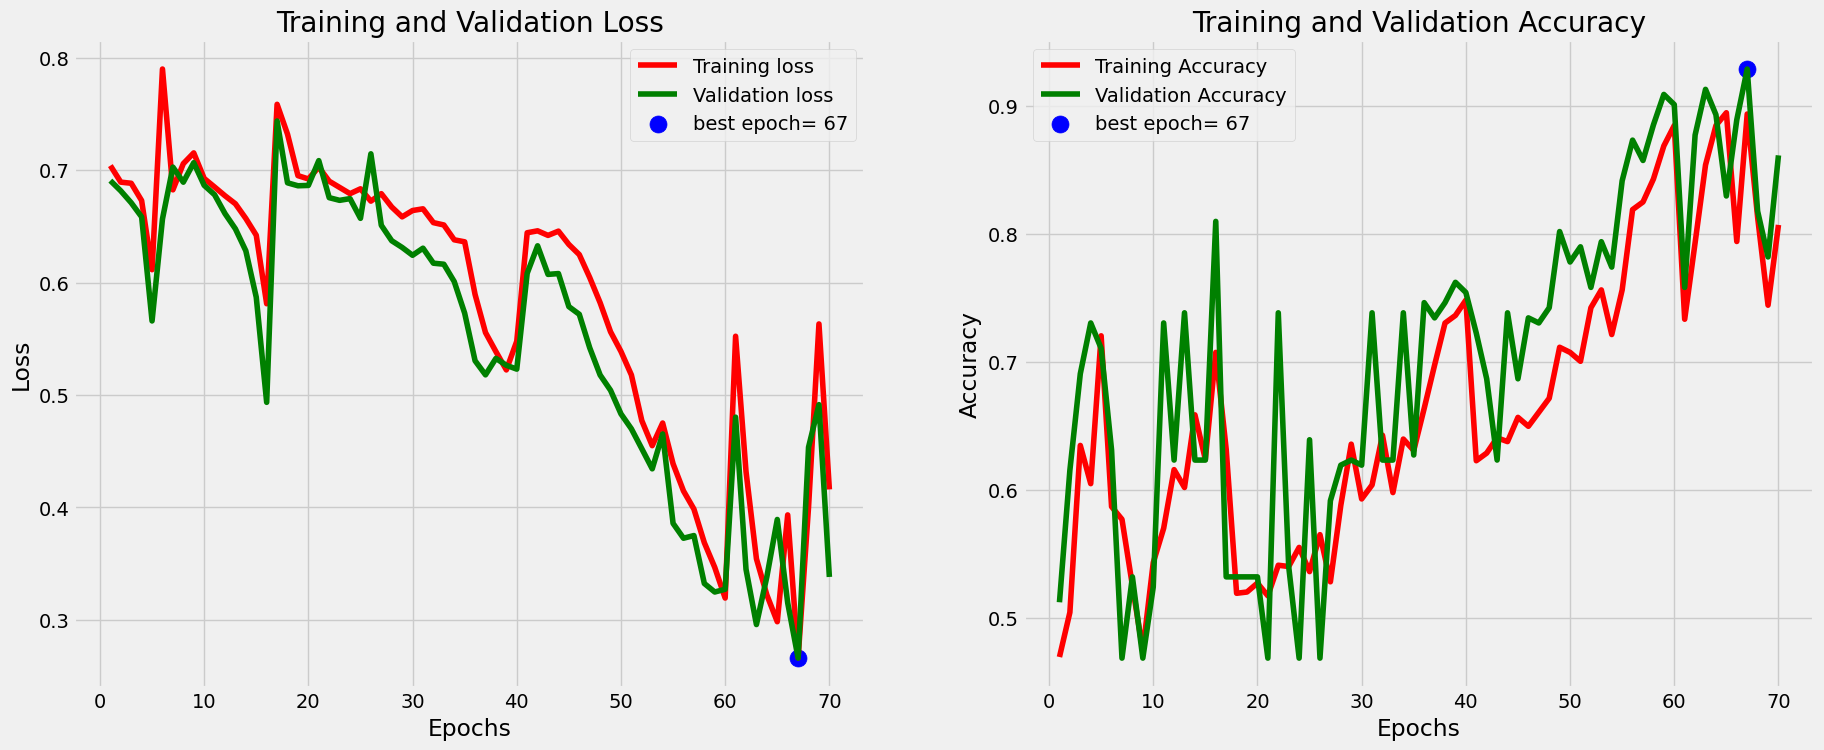

In [16]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [17]:
# Muat bobot dari file HDF5
model.load_weights('Checkpoints/model_epoch_67.h5')

In [18]:
y_pred_prob = model.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

8/8 [==============================] - 0s 5ms/step
Accuracy: 0.93
Precision: 0.91
Recall: 0.94
F1-Score: 0.93


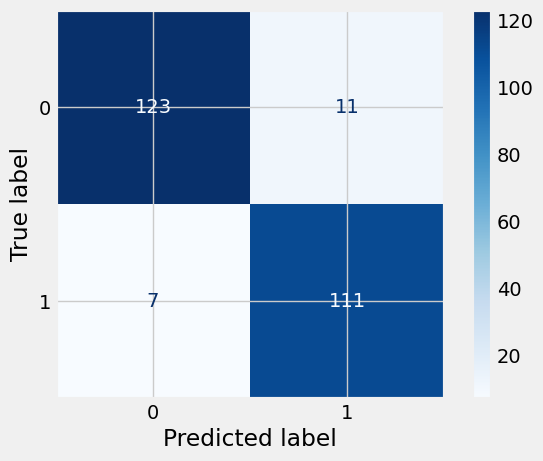

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()